#### Python code that allows the financing team to enact Money at a fixed rate for an unsecured purchase (e.g. credit card) for an individual

By using the various ML models & EDA we can factor out which features are significant & based on those features we can predict & lend loan for an unsecured purchase.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

sns.set_style('whitegrid')

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [38]:
df = pd.read_csv("/home/aniketkhanchi/workspace/ML_Projects/Credit_Risk_Analysis/german_credit_data.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [39]:
display(Markdown("#### Explore the Values of Text Columns:"))
cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
for col in cols:
    line = "**" + col + ":** "
    for v in df[col].unique():
        line = line + str(v) + ", "
    display(Markdown(line))

#### Explore the Values of Text Columns:

**Sex:** male, female, 

**Housing:** own, free, rent, 

**Saving accounts:** nan, little, quite rich, rich, moderate, 

**Checking account:** little, moderate, nan, rich, 

**Purpose:** radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others, 

**Risk:** good, bad, 

In [40]:
# label encode account quality and fill NaN with 0
def SC_LabelEncoder(text):
    if text == "little":
        return 1
    elif text == "moderate":
        return 2
    elif text == "quite rich":
        return 3
    elif text == "rich":
        return 4
    else:
        return 0

df["Saving accounts"] = df["Saving accounts"].apply(SC_LabelEncoder)
df["Checking account"] = df["Checking account"].apply(SC_LabelEncoder)

In [41]:
# label encode account quality and fill NaN with 0
def H_LabelEncoder(text):
    if text == "free":
        return 0
    elif text == "rent":
        return 1
    elif text == "own":
        return 2

df["Housing"] = df["Housing"].apply(H_LabelEncoder)

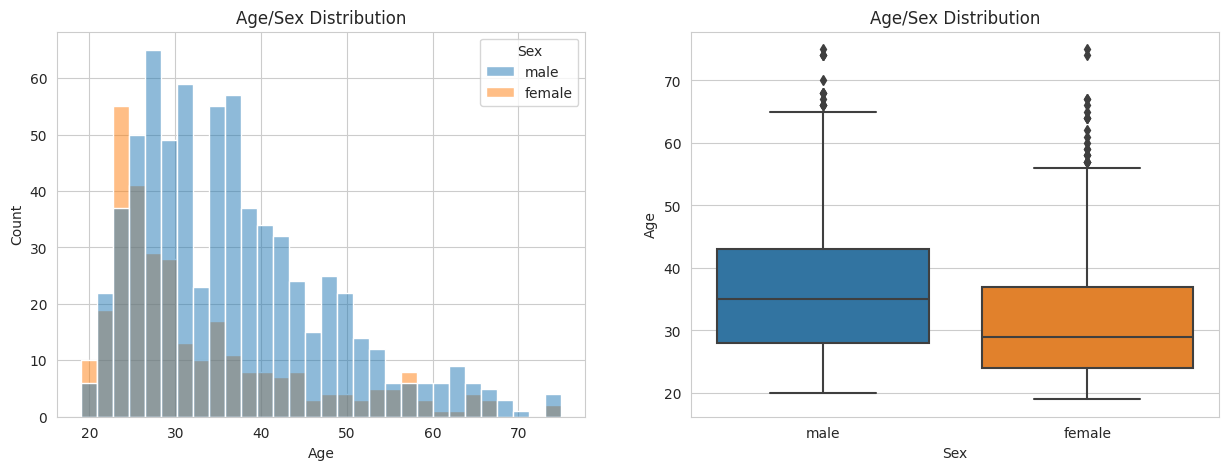

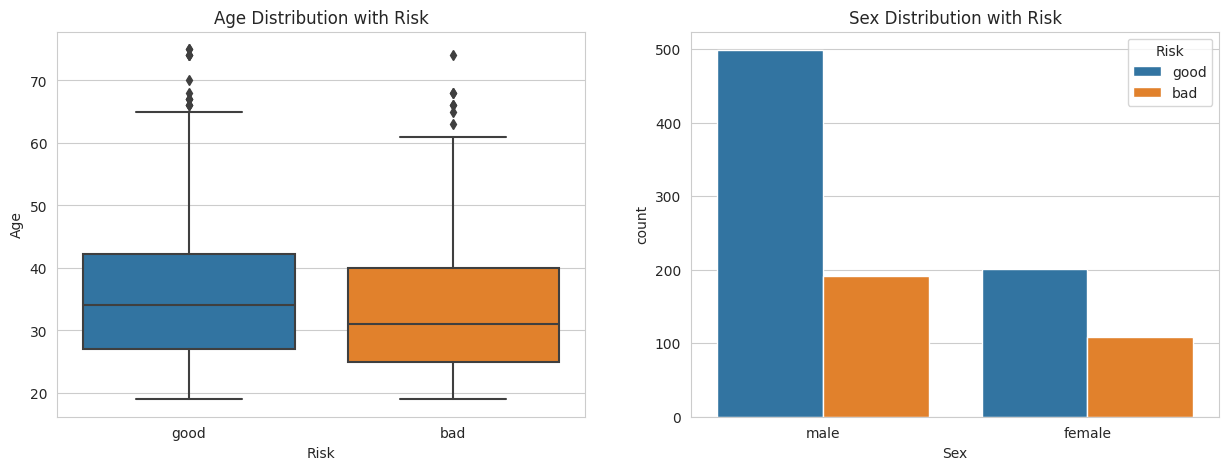

In [42]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df, x='Age', bins=30, hue="Sex", ax=ax[0]).set_title("Age/Sex Distribution");
sns.boxplot(data=df, x="Sex", y="Age", ax=ax[1]).set_title("Age/Sex Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df, x='Risk', y='Age', ax=ax[0]).set_title("Age Distribution with Risk");
sns.countplot(data=df, x="Sex", hue="Risk", ax=ax[1]).set_title("Sex Distribution with Risk");

**Analysis:** 
- Age does not affect the risk rating much. 
- Males take more count of credit from Bank.
- Males have lower percentage of bad rating than woman.

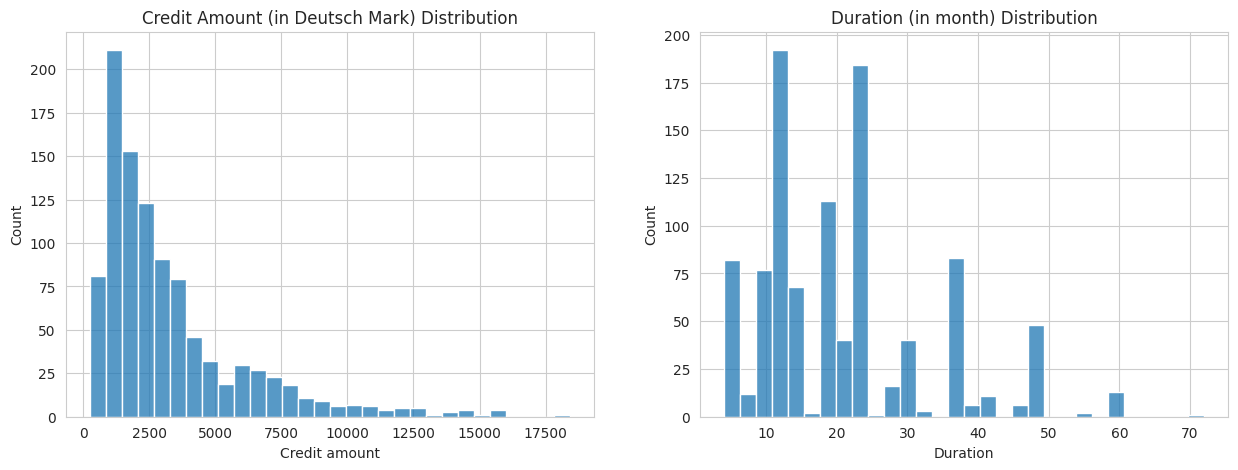

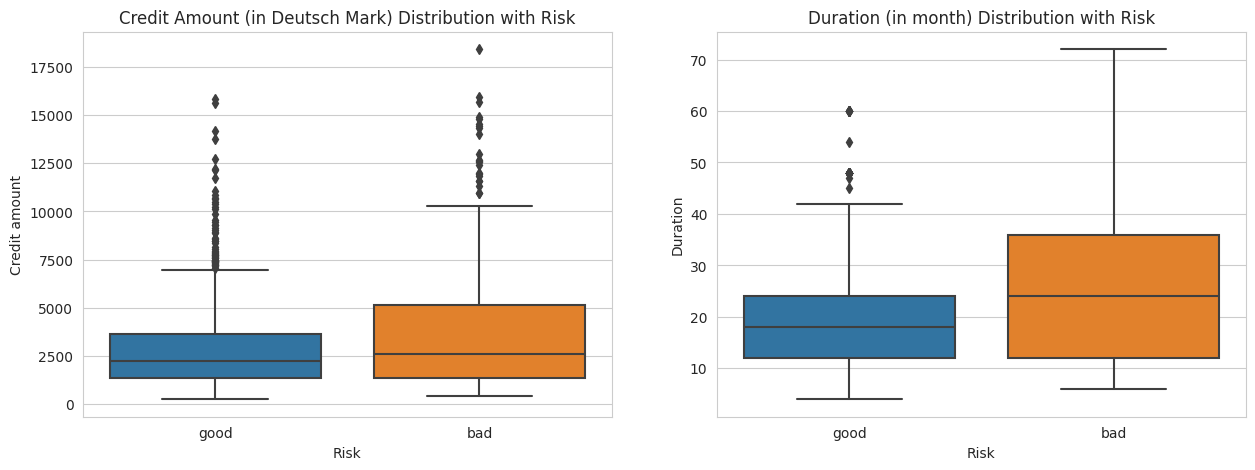

In [43]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df, x='Credit amount', bins=30, ax=ax[0]).set_title("Credit Amount (in Deutsch Mark) Distribution");
sns.histplot(df, x='Duration', bins=30, ax=ax[1]).set_title("Duration (in month) Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df, x='Risk', y='Credit amount', ax=ax[0]).set_title("Credit Amount (in Deutsch Mark) Distribution with Risk");
sns.boxplot(data=df, x='Risk', y='Duration', ax=ax[1]).set_title("Duration (in month) Distribution with Risk");

**Analysis:** The higher credit amount and longer duration means higher risk to the bank.

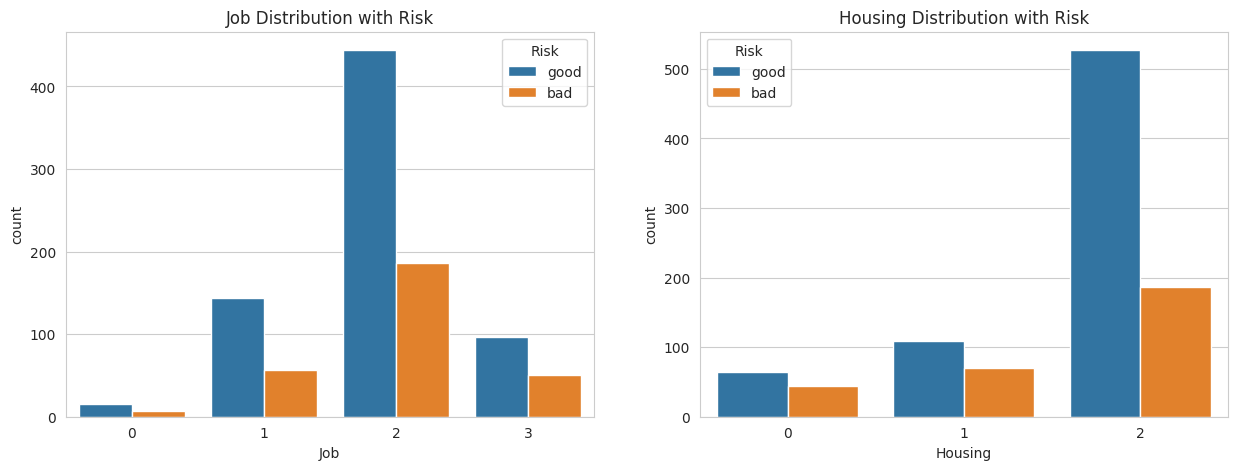

In [44]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=df, x="Job", hue="Risk", ax=ax[0]).set_title("Job Distribution with Risk");
sns.countplot(data=df, x="Housing", hue="Risk", ax=ax[1]).set_title("Housing Distribution with Risk");

**Analysis:** 
- Most of people in records have job skill level 2, but the job skill level does not affect the risk rating much.
- People who own a house means low risk and good rating to the bank.

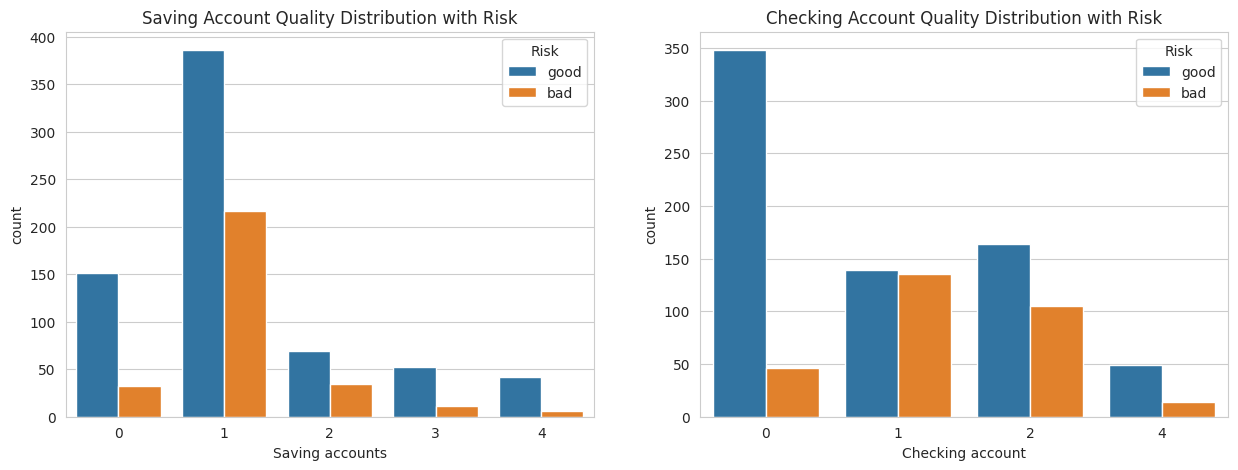

In [45]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=df, x="Saving accounts", hue="Risk", ax=ax[0]).set_title("Saving Account Quality Distribution with Risk");
sns.countplot(data=df, x="Checking account", hue="Risk", ax=ax[1]).set_title("Checking Account Quality Distribution with Risk");

**Analysis** (since 0 means unknown, only discuss quality level 1 to 4):
- The person with more saving means less risk to the bank, but most people in the records have little saving (not rich!)
- About half of people who have little checking account are considered as bad rating in risk.
- About 20% of people who have moderate checking account are considered as bad rating in risk.

In [46]:
# use LabelEncoder() to encode other categorical columns:
for col in ["Sex", "Purpose", "Risk"]:
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,2,0,1,1169,6,5,1
1,22,0,2,2,1,2,5951,48,5,0
2,49,1,1,2,1,0,2096,12,3,1
3,45,1,2,0,1,1,7882,42,4,1
4,53,1,2,0,1,1,4870,24,1,0


## 5. Predicting the Risk
**Based on given Risk column**

In [47]:
X, y = df.drop("Risk", axis=1), df["Risk"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=0)

### 5.1 K-Nearest Neighbors Classification

In [48]:
max_score = 0
max_k = 0
for k in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train,y_train)
    score = f1_score(y_test, neigh.predict(X_test))
    if score > max_score:
        max_k = k
        max_score = score

display(Markdown("If use K-Nearest Neighbors Classification, the k should be " + str(max_k) + " to get best prediction, and then the  mean accuracy is " + str(max_score)))

If use K-Nearest Neighbors Classification, the k should be 69 to get best prediction, and then the  mean accuracy is 0.8352941176470587

### 5.2 Modeling by Other Classifiers
Since KNN algorithm cost lots of memory and time for prediction, this section want to try some more classifiers.
#### Model Selection with Cross Validate

In [49]:
# define models
Models = {
    "SVC": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GaussianNaiveBayes": GaussianNB()
}

In [63]:
cv_results = pd.DataFrame(columns=['model', 'train_score', 'test_score','fit_time','score_time'])
for key in Models.keys():
    cv_res = model_selection.cross_validate(Models[key], X_train, y_train, 
                                             return_train_score=True,
                                             scoring="f1",
                                             cv=5, n_jobs=-1)

    res = {
        'model': key, 
        'train_score': str(cv_res["train_score"].mean()), 
        'test_score': str(cv_res["test_score"].mean()),
        'fit_time': str(cv_res["fit_time"].mean()),
        'score_time': str(cv_res["score_time"].mean()),
        }
    new_row_df = pd.DataFrame([res])

    cv_results = pd.concat([cv_results,new_row_df], ignore_index=True)
    print("CV for model:", key, "done.")
cv_results

CV for model: SVC done.
CV for model: DecisionTree done.
CV for model: RandomForest done.
CV for model: GaussianNaiveBayes done.


,model,train_score,test_score,fit_time,score_time
0,SVC,0.8260447063255423,0.8260719864804834,0.04286050796508789,0.015450477600097656
1,DecisionTree,1.0,0.7485164007001347,0.010851478576660157,0.009902620315551757
2,RandomForest,1.0,0.8220141710715827,0.5764788150787353,0.049661874771118164
3,GaussianNaiveBayes,0.8120507967282343,0.8112651977900185,0.009323549270629884,0.011624431610107422


#### Evaluate Model on Testing Set
- Random Forest Classifier gives a good result on both train_score and test_score.
- SVC and Gaussian Naive Bayes show the less over-fiting.
- Gaussian Naive Bayes Classifier has least runtime.
- Random Forest Classifier would tell feature importances, while SVC only return coef_ in the case of a linear kernel, which will be too slow.

**Taking all this into consideration, Random Forest Classifier is chose to evaluate on testing set:**

In [29]:
rf = Models["RandomForest"].fit(X_train, y_train)
print('f1_score:', f1_score(y_test, rf.predict(X_test)))

f1_score: 0.8417508417508417


#### Feature Importance Discussion

In [30]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train.columns
feature_importance["importance"] = rf.feature_importances_
feature_importance = feature_importance.sort_values("importance", ascending=False)
feature_importance

,feature,importance
6,Credit amount,0.260733
0,Age,0.181466
7,Duration,0.156174
5,Checking account,0.128960
8,Purpose,0.083915
4,Saving accounts,0.064188
2,Job,0.053592
3,Housing,0.041529
1,Sex,0.029443
